Import the requirements

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset and inspect its contents
data = pd.read_csv('process_data.csv')
attack_data = pd.read_csv('process_data_exploit.csv')

# List of numerical columns to be used for analysis
numerical_columns = ['Normalized CPU Usage (%)', 'Process Memory Usage (%)', 
                     'Bytes Sent (Network)', 'Bytes Received (Network)', 
                     'Disk Read (Bytes)', 'Disk Write (Bytes)']

# Display basic information about the dataset and its first few rows
data.info()
data_head = data.head()
data_head

attack_data.info()
attack_data_head = attack_data.head()
attack_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610535 entries, 0 to 610534
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Timestamp                 610535 non-null  object 
 1   Process Name              610535 non-null  object 
 2   Process ID                610535 non-null  int64  
 3   Normalized CPU Usage (%)  610535 non-null  float64
 4   Process Memory Usage (%)  610535 non-null  float64
 5   Bytes Sent (Network)      610535 non-null  int64  
 6   Bytes Received (Network)  610535 non-null  int64  
 7   Disk Read (Bytes)         610535 non-null  int64  
 8   Disk Write (Bytes)        610535 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 41.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727525 entries, 0 to 727524
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------

,Timestamp,Process Name,Process ID,Normalized CPU Usage (%),Process Memory Usage (%),Bytes Sent (Network),Bytes Received (Network),Disk Read (Bytes),Disk Write (Bytes)
0,2024-09-14 21:02:31,systemd,1,0.0,0.23,0,0,233018368,638976
1,2024-09-14 21:02:31,kthreadd,2,0.0,0.00,0,0,0,0
2,2024-09-14 21:02:31,pool_workqueue_release,3,0.0,0.00,0,0,0,0
3,2024-09-14 21:02:31,kworker/R-rcu_g,4,0.0,0.00,0,0,0,0
4,2024-09-14 21:02:31,kworker/R-rcu_p,5,0.0,0.00,0,0,0,0


In [5]:
# Remove processes where all numerical columns have zero values
zero_processes = data.groupby('Process Name').filter(lambda x: (x[numerical_columns] == 0).all(axis=1).all())['Process Name'].unique()
non_zero_data = data[~data['Process Name'].isin(zero_processes)]

zero_processes_exploit = attack_data.groupby('Process Name').filter(lambda x: (x[numerical_columns] == 0).all(axis=1).all())['Process Name'].unique()
non_zero_data_exploit = attack_data[~attack_data['Process Name'].isin(zero_processes_exploit)]

non_zero_data.info()
non_zero_data_exploit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466983 entries, 0 to 610534
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Timestamp                 466983 non-null  object 
 1   Process Name              466983 non-null  object 
 2   Process ID                466983 non-null  int64  
 3   Normalized CPU Usage (%)  466983 non-null  float64
 4   Process Memory Usage (%)  466983 non-null  float64
 5   Bytes Sent (Network)      466983 non-null  int64  
 6   Bytes Received (Network)  466983 non-null  int64  
 7   Disk Read (Bytes)         466983 non-null  int64  
 8   Disk Write (Bytes)        466983 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 35.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 542614 entries, 0 to 727524
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  

We have performed the data cleaning, now let's proceed with analytics and visualizations.

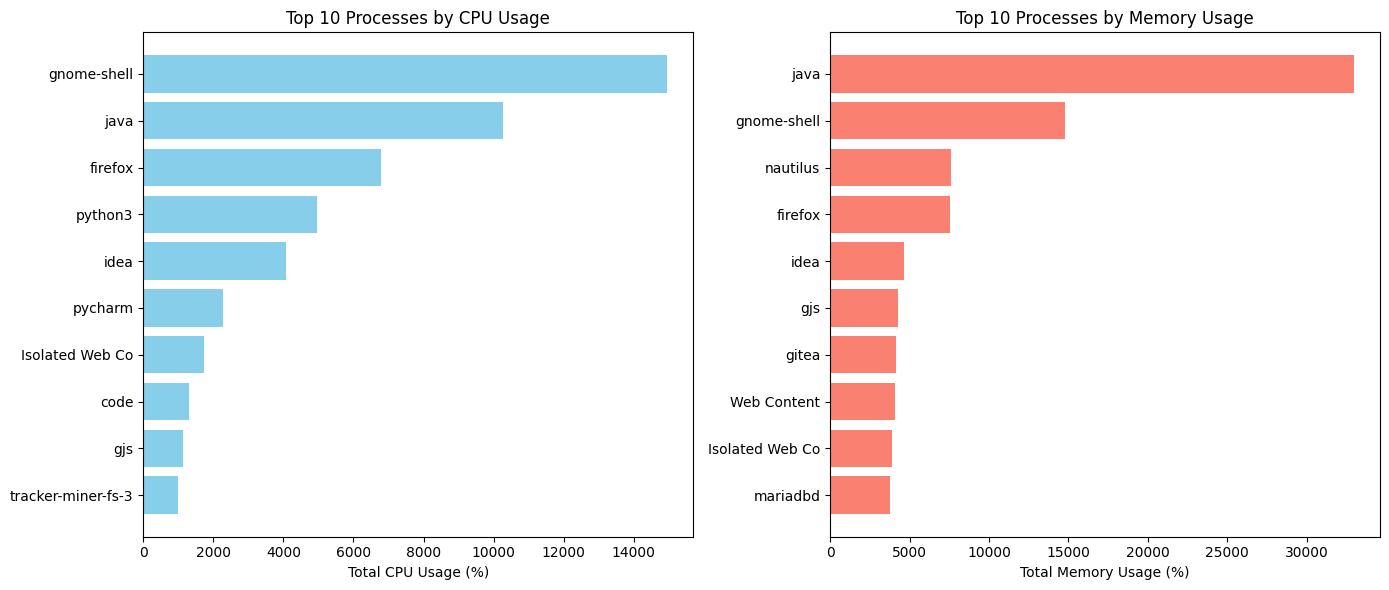

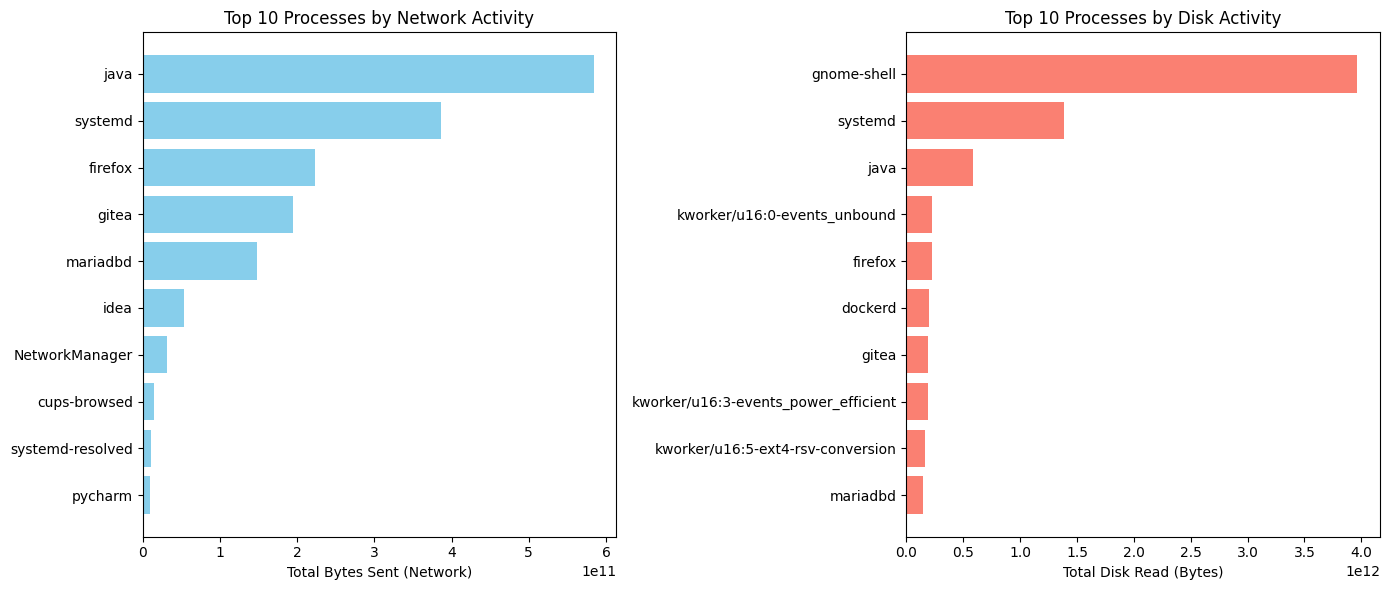

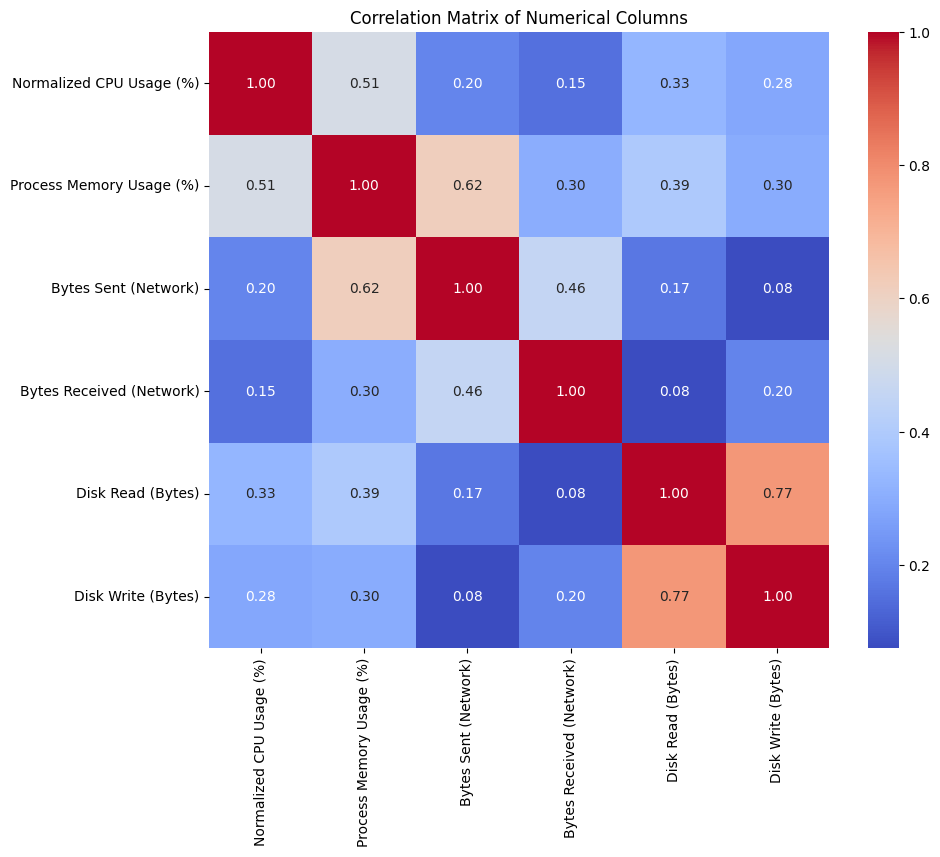

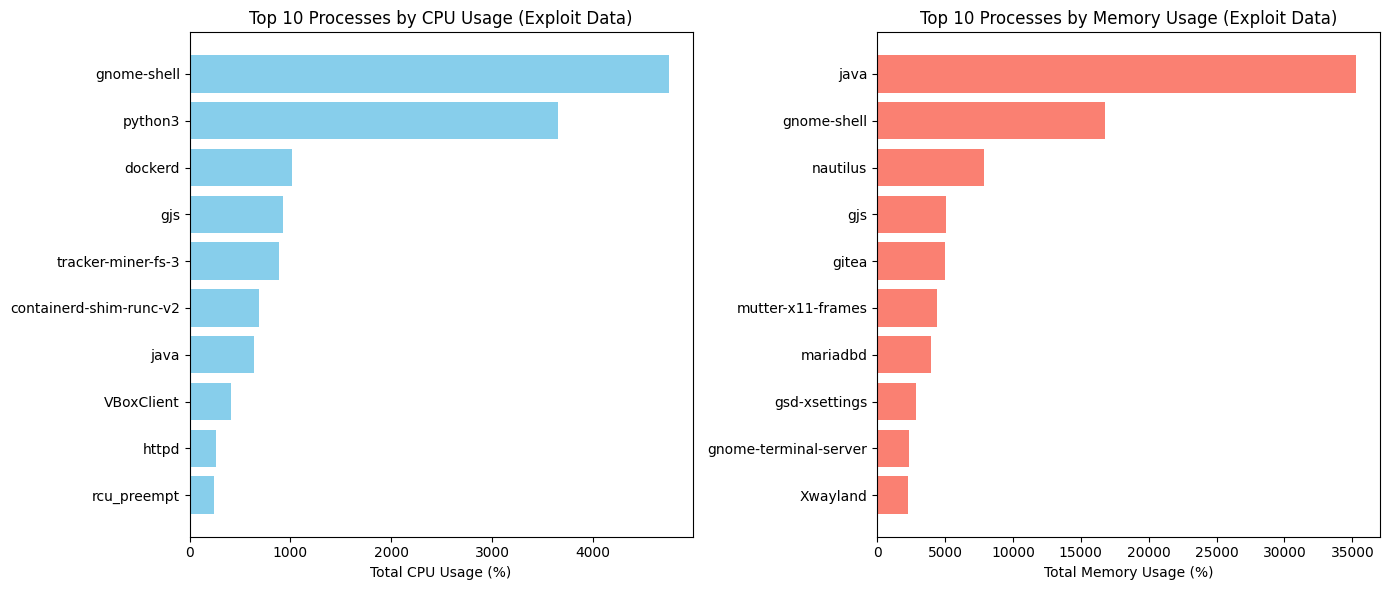

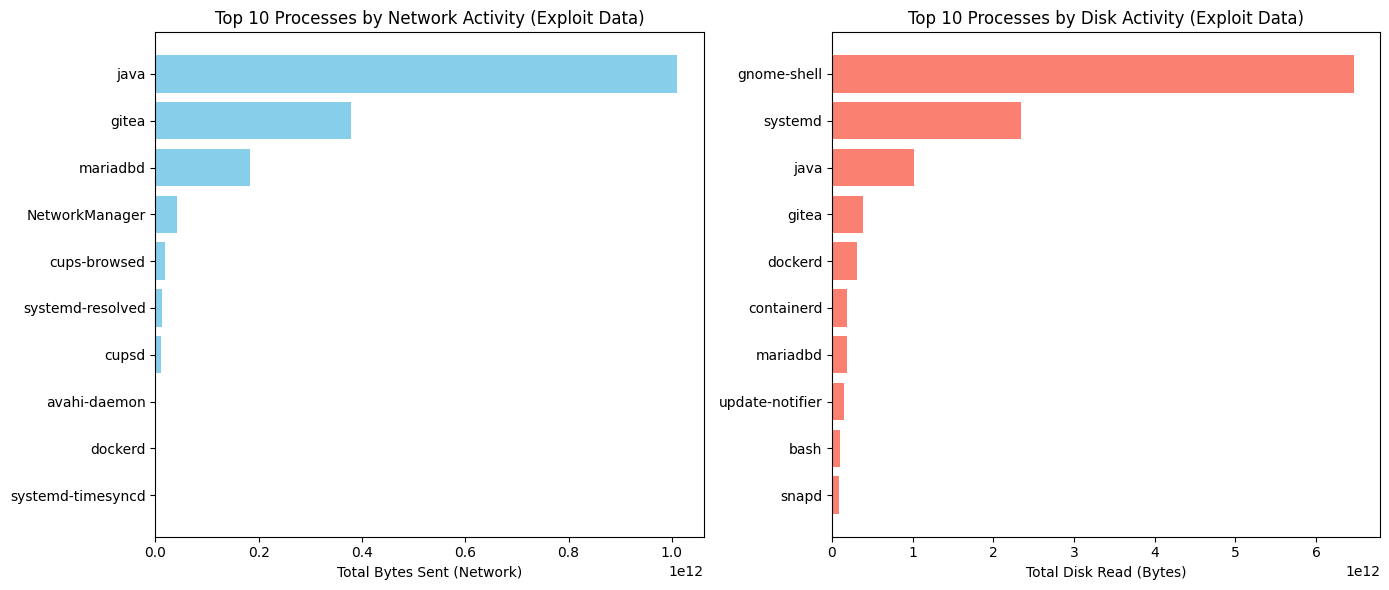

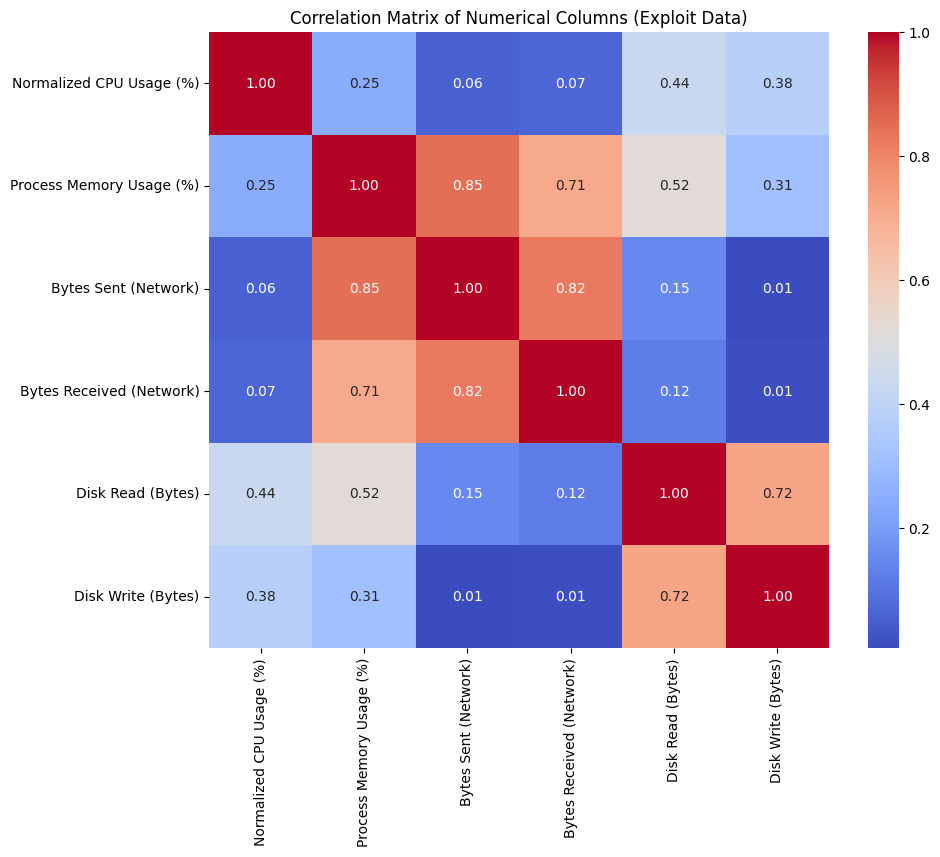

In [3]:
# Descriptive statistics for the filtered dataset
desc_stats_filtered = non_zero_data[numerical_columns].describe()

# Count of processes
process_counts = non_zero_data['Process Name'].value_counts()

# Aggregated analysis of CPU and Memory usage per process
cpu_memory_usage = non_zero_data.groupby('Process Name').agg({
    'Normalized CPU Usage (%)': 'sum',
    'Process Memory Usage (%)': 'sum'
}).sort_values(by='Normalized CPU Usage (%)', ascending=False)

# Aggregated analysis of network and disk activity per process
network_disk_activity = non_zero_data.groupby('Process Name').agg({
    'Bytes Sent (Network)': 'sum',
    'Bytes Received (Network)': 'sum',
    'Disk Read (Bytes)': 'sum',
    'Disk Write (Bytes)': 'sum'
}).sort_values(by='Bytes Sent (Network)', ascending=False)

# Correlation matrix for numerical columns
correlation_matrix = non_zero_data[numerical_columns].corr()

# Visualization of CPU and Memory usage
plt.figure(figsize=(14, 6))

# Bar chart for top CPU usage processes
plt.subplot(1, 2, 1)
top_cpu_processes = cpu_memory_usage.head(10)
plt.barh(top_cpu_processes.index, top_cpu_processes['Normalized CPU Usage (%)'], color='skyblue')
plt.xlabel('Total CPU Usage (%)')
plt.title('Top 10 Processes by CPU Usage')
plt.gca().invert_yaxis()

# Bar chart for top Memory usage processes
plt.subplot(1, 2, 2)
top_memory_processes = cpu_memory_usage.sort_values(by='Process Memory Usage (%)', ascending=False).head(10)
plt.barh(top_memory_processes.index, top_memory_processes['Process Memory Usage (%)'], color='salmon')
plt.xlabel('Total Memory Usage (%)')
plt.title('Top 10 Processes by Memory Usage')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Similar visualization for network and disk activity
plt.figure(figsize=(14, 6))

# Bar chart for top network activity processes
plt.subplot(1, 2, 1)
top_network_processes = network_disk_activity.head(10)
plt.barh(top_network_processes.index, top_network_processes['Bytes Sent (Network)'], color='skyblue')
plt.xlabel('Total Bytes Sent (Network)')
plt.title('Top 10 Processes by Network Activity')
plt.gca().invert_yaxis()

# Bar chart for top disk activity processes
plt.subplot(1, 2, 2)
top_disk_processes = network_disk_activity.sort_values(by='Disk Read (Bytes)', ascending=False).head(10)
plt.barh(top_disk_processes.index, top_disk_processes['Disk Read (Bytes)'], color='salmon')
plt.xlabel('Total Disk Read (Bytes)')
plt.title('Top 10 Processes by Disk Activity')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

# Repeat the same analysis for the exploit dataset

# Descriptive statistics for the filtered exploit dataset
desc_stats_filtered_exploit = non_zero_data_exploit[numerical_columns].describe()

# Count of processes in exploit data
process_counts_exploit = non_zero_data_exploit['Process Name'].value_counts()

# Aggregated analysis of CPU and Memory usage per process
cpu_memory_usage_exploit = non_zero_data_exploit.groupby('Process Name').agg({
    'Normalized CPU Usage (%)': 'sum',
    'Process Memory Usage (%)': 'sum'
}).sort_values(by='Normalized CPU Usage (%)', ascending=False)

# Aggregated analysis of network and disk activity per process
network_disk_activity_exploit = non_zero_data_exploit.groupby('Process Name').agg({
    'Bytes Sent (Network)': 'sum',
    'Bytes Received (Network)': 'sum',
    'Disk Read (Bytes)': 'sum',
    'Disk Write (Bytes)': 'sum'
}).sort_values(by='Bytes Sent (Network)', ascending=False)

# Correlation matrix for exploit dataset
correlation_matrix_exploit = non_zero_data_exploit[numerical_columns].corr()

# Visualization of CPU and Memory usage for exploit data
plt.figure(figsize=(14, 6))

# Bar chart for top CPU usage processes in exploit data
plt.subplot(1, 2, 1)
top_cpu_processes_exploit = cpu_memory_usage_exploit.head(10)
plt.barh(top_cpu_processes_exploit.index, top_cpu_processes_exploit['Normalized CPU Usage (%)'], color='skyblue')
plt.xlabel('Total CPU Usage (%)')
plt.title('Top 10 Processes by CPU Usage (Exploit Data)')
plt.gca().invert_yaxis()

# Bar chart for top Memory usage processes in exploit data
plt.subplot(1, 2, 2)
top_memory_processes_exploit = cpu_memory_usage_exploit.sort_values(by='Process Memory Usage (%)', ascending=False).head(10)
plt.barh(top_memory_processes_exploit.index, top_memory_processes_exploit['Process Memory Usage (%)'], color='salmon')
plt.xlabel('Total Memory Usage (%)')
plt.title('Top 10 Processes by Memory Usage (Exploit Data)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Similar visualization for network and disk activity in exploit data
plt.figure(figsize=(14, 6))

# Bar chart for top network activity processes in exploit data
plt.subplot(1, 2, 1)
top_network_processes_exploit = network_disk_activity_exploit.head(10)
plt.barh(top_network_processes_exploit.index, top_network_processes_exploit['Bytes Sent (Network)'], color='skyblue')
plt.xlabel('Total Bytes Sent (Network)')
plt.title('Top 10 Processes by Network Activity (Exploit Data)')
plt.gca().invert_yaxis()

# Bar chart for top disk activity processes in exploit data
plt.subplot(1, 2, 2)
top_disk_processes_exploit = network_disk_activity_exploit.sort_values(by='Disk Read (Bytes)', ascending=False).head(10)
plt.barh(top_disk_processes_exploit.index, top_disk_processes_exploit['Disk Read (Bytes)'], color='salmon')
plt.xlabel('Total Disk Read (Bytes)')
plt.title('Top 10 Processes by Disk Activity (Exploit Data)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Heatmap of the correlation matrix for exploit data
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_exploit, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns (Exploit Data)')
plt.show()

# Proceed with the rest of the processing

Preprocess the data

In [45]:
# Split the clean data (80/20) and reset index to preserve Timestamp
train_data_clean, test_data_clean = train_test_split(non_zero_data, test_size=0.1, random_state=42)
train_data_clean.reset_index(drop=False, inplace=True)  # Keep original index with Timestamp
test_data_clean.reset_index(drop=False, inplace=True)   # Keep original index with Timestamp

# Normalize the features for training using PowerTransformer
scaler = PowerTransformer()
scaled_train_data = scaler.fit_transform(train_data_clean[numerical_columns])
scaled_test_data = scaler.transform(test_data_clean[numerical_columns])
scaled_attack_data = scaler.transform(non_zero_data_exploit[numerical_columns])

# Concatenate the test and exploit datasets
combined_data = pd.concat([test_data_clean, non_zero_data_exploit], ignore_index=True)
scaled_combined_data = np.vstack([scaled_test_data, scaled_attack_data])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 principal components
scaled_train_data_pca = pca.fit_transform(scaled_train_data)
scaled_combined_data_pca = pca.transform(scaled_combined_data)

# Assign True Labels: 1 for normal data, -1 for anomalies (exploit data)
combined_data['True Labels'] = [1] * len(test_data_clean) + [-1] * len(non_zero_data_exploit)

Model Setup

In [46]:
# Function to train a model, make predictions, visualize anomalies, and plot confusion matrix
def train_and_plot_anomalies(model_name, model, pca_train_data, pca_combined_data, combined_data, threshold=None):
    model.fit(pca_train_data)
    scores = model.decision_function(pca_combined_data) if hasattr(model, 'decision_function') else model.predict(pca_combined_data)
    
    # If a custom threshold is provided, use it; otherwise, use model's default prediction method
    if threshold is not None:
        predictions = np.where(scores < threshold, -1, 1)
    else:
        predictions = model.predict(pca_combined_data)
    
    combined_data[f'{model_name} Anomaly'] = predictions  # Save anomaly predictions for each model in a separate column
    
    # Visualize the results
    plot_anomalies(model_name, combined_data)
    
    # Evaluate with confusion matrix
    evaluate_metrics(model_name, combined_data['True Labels'], predictions)

# Function to visualize anomalies in scatter plots
def plot_anomalies(model_name, combined_data):
    anomalies = combined_data[combined_data[f'{model_name} Anomaly'] == -1]

    # Plotting CPU Usage vs. Memory Usage
    plt.figure(figsize=(14, 6))
    plt.scatter(combined_data['Normalized CPU Usage (%)'], combined_data['Process Memory Usage (%)'], 
                color='blue', label='Normal', alpha=0.5)
    plt.scatter(anomalies['Normalized CPU Usage (%)'], anomalies['Process Memory Usage (%)'], 
                color='red', label='Anomaly', alpha=0.7)
    plt.xlabel('Normalized CPU Usage (%)')
    plt.ylabel('Process Memory Usage (%)')
    plt.title(f'CPU Usage vs. Memory Usage (Anomalies Highlighted) - {model_name}')
    plt.legend()
    plt.show()

    # Plotting Network Bytes Sent vs. Disk Read Bytes
    plt.figure(figsize=(14, 6))
    plt.scatter(combined_data['Bytes Sent (Network)'], combined_data['Disk Read (Bytes)'], 
                color='blue', label='Normal', alpha=0.5)
    plt.scatter(anomalies['Bytes Sent (Network)'], anomalies['Disk Read (Bytes)'], 
                color='red', label='Anomaly', alpha=0.7)
    plt.xlabel('Bytes Sent (Network)')
    plt.ylabel('Disk Read (Bytes)')
    plt.title(f'Network Bytes Sent vs. Disk Read Bytes (Anomalies Highlighted) - {model_name}')
    plt.legend()
    plt.show()


# Function to calculate and display evaluation metrics (confusion matrix, precision, recall, F1-score)
def evaluate_metrics(model_name, true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Calculate and display precision, recall, F1-score, and other metrics
    precision = precision_score(true_labels, predictions, pos_label=-1, zero_division=0)
    recall = recall_score(true_labels, predictions, pos_label=-1, zero_division=0)
    f1 = f1_score(true_labels, predictions, pos_label=-1, zero_division=0)
    
    print(f"\n### {model_name} ###")
    print(f"Precision for {model_name}: {precision:.4f}")
    print(f"Recall for {model_name}: {recall:.4f}")
    print(f"F1-Score for {model_name}: {f1:.4f}")
    
    # Generate classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(true_labels, predictions, target_names=['Normal', 'Anomaly'], zero_division=0))


Train models and visualize results

Elliptic Envelope model

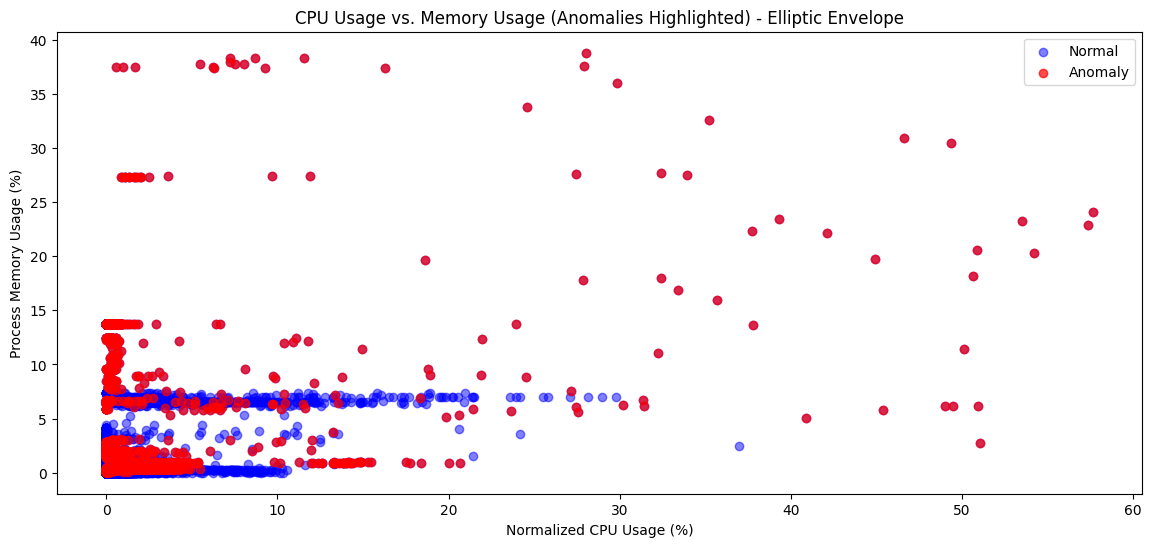

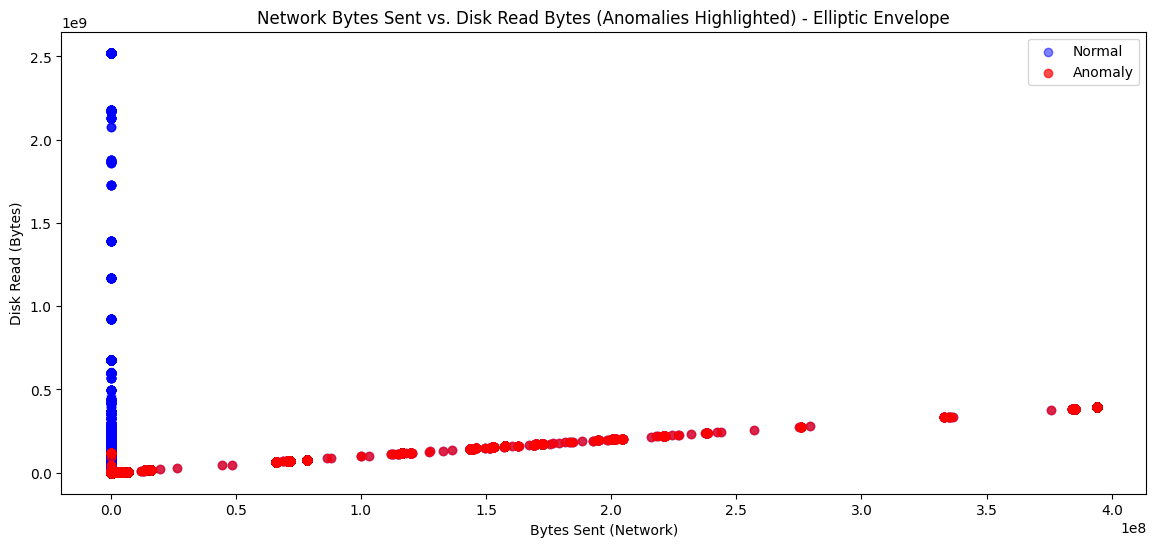

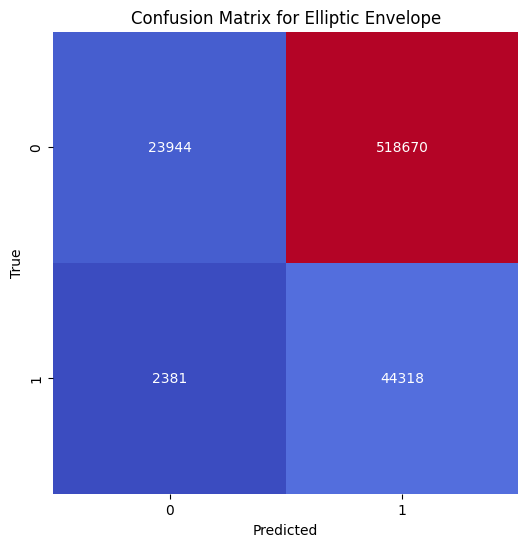


### Elliptic Envelope ###
Precision for Elliptic Envelope: 0.9096
Recall for Elliptic Envelope: 0.0441
F1-Score for Elliptic Envelope: 0.0842
Classification Report for Elliptic Envelope:

              precision    recall  f1-score   support

      Normal       0.91      0.04      0.08    542614
     Anomaly       0.08      0.95      0.15     46699

    accuracy                           0.12    589313
   macro avg       0.49      0.50      0.11    589313
weighted avg       0.84      0.12      0.09    589313



In [47]:
elliptic_model = EllipticEnvelope(contamination=0.05, support_fraction=0.7)
train_and_plot_anomalies('Elliptic Envelope', elliptic_model, scaled_train_data_pca, scaled_combined_data_pca, combined_data, threshold=-0.2)

Isolation Forest model

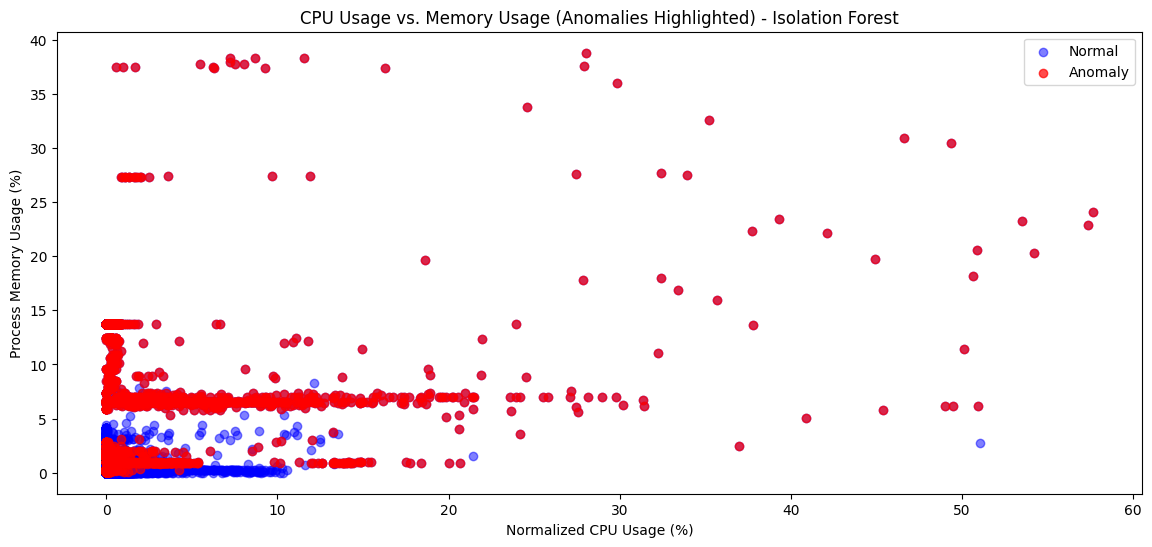

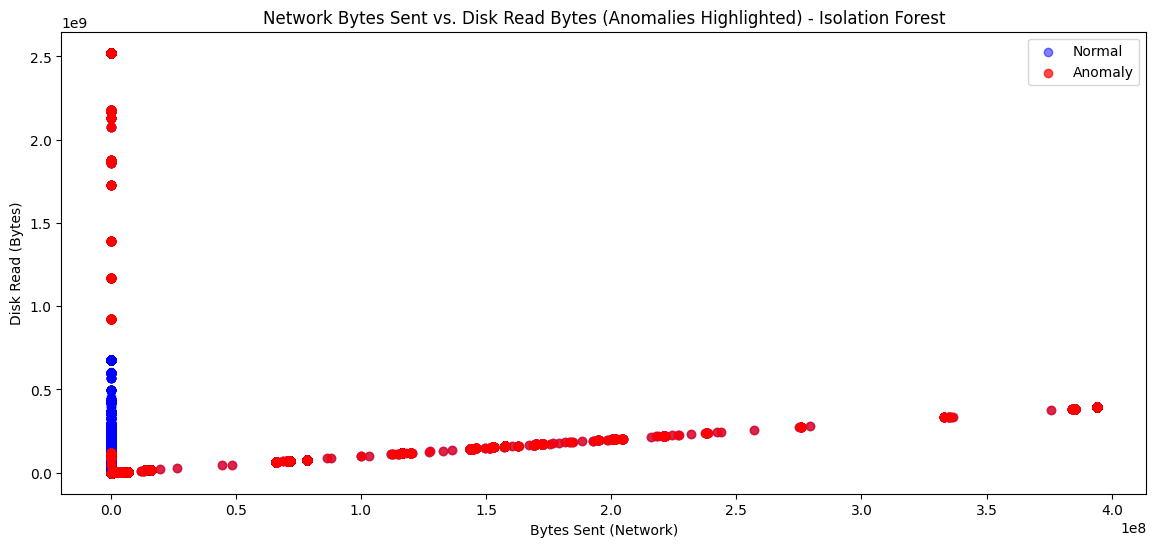

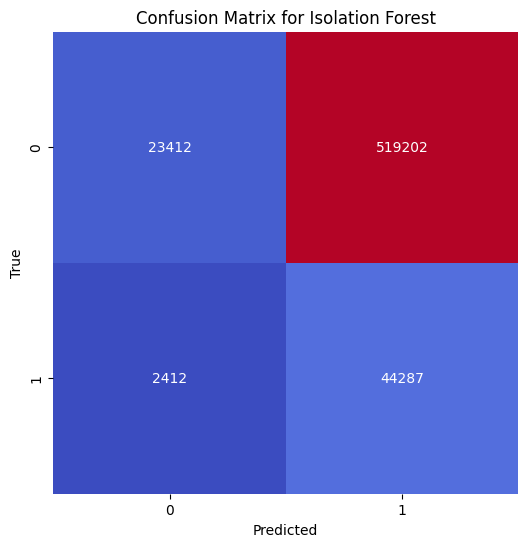


### Isolation Forest ###
Precision for Isolation Forest: 0.9066
Recall for Isolation Forest: 0.0431
F1-Score for Isolation Forest: 0.0824
Classification Report for Isolation Forest:

              precision    recall  f1-score   support

      Normal       0.91      0.04      0.08    542614
     Anomaly       0.08      0.95      0.15     46699

    accuracy                           0.11    589313
   macro avg       0.49      0.50      0.11    589313
weighted avg       0.84      0.11      0.09    589313



In [48]:
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
train_and_plot_anomalies('Isolation Forest', isolation_forest, scaled_train_data_pca, scaled_combined_data_pca, combined_data)

One-Class SVM model

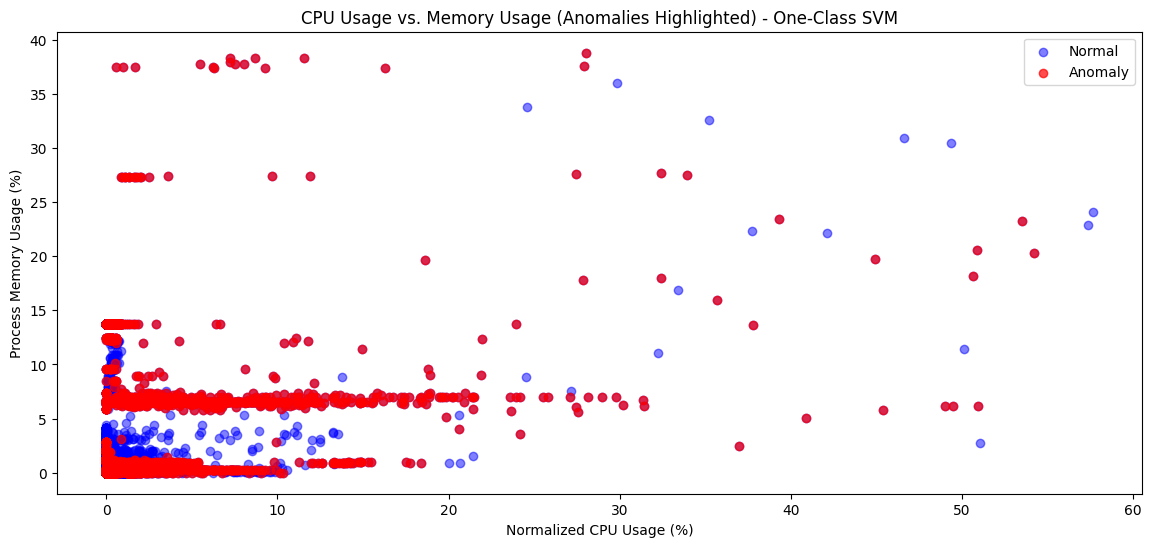

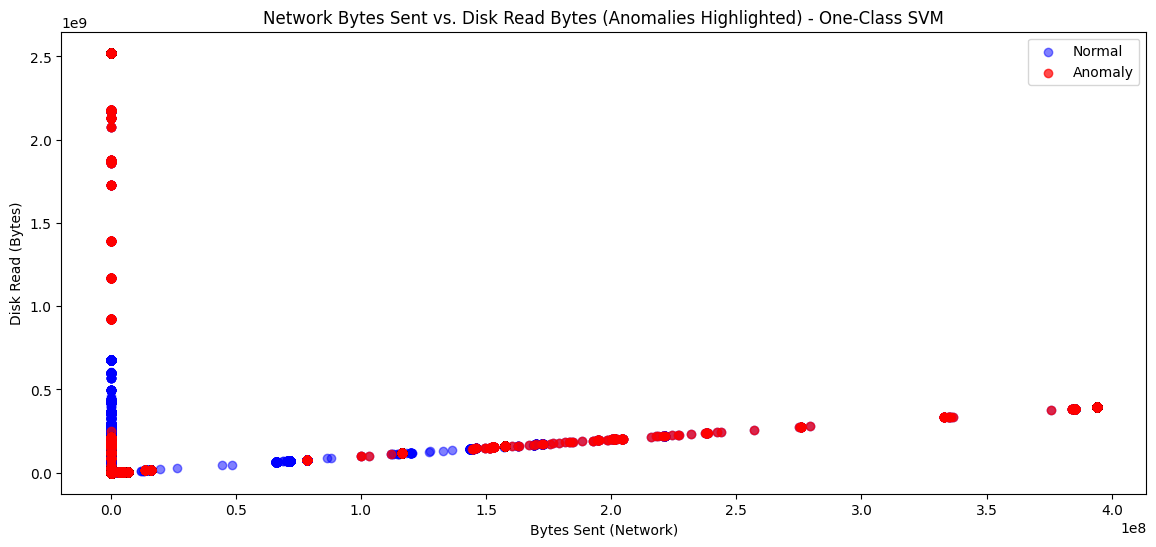

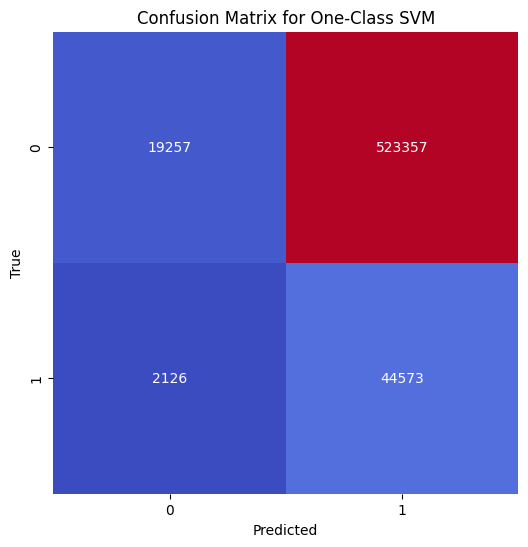


### One-Class SVM ###
Precision for One-Class SVM: 0.9006
Recall for One-Class SVM: 0.0355
F1-Score for One-Class SVM: 0.0683
Classification Report for One-Class SVM:

              precision    recall  f1-score   support

      Normal       0.90      0.04      0.07    542614
     Anomaly       0.08      0.95      0.15     46699

    accuracy                           0.11    589313
   macro avg       0.49      0.49      0.11    589313
weighted avg       0.84      0.11      0.07    589313



In [49]:
svm_model = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
train_and_plot_anomalies('One-Class SVM', svm_model, scaled_train_data_pca, scaled_combined_data_pca, combined_data)

Save the combined data with anomaly predictions for each model

In [50]:
combined_data.to_csv('combined_data_with_separate_anomalies_and_confusion_matrix.csv', index=False)

Decision Fusion

Current columns in combined_data before fusion: Index(['index', 'Timestamp', 'Process Name', 'Process ID',
       'Normalized CPU Usage (%)', 'Process Memory Usage (%)',
       'Bytes Sent (Network)', 'Bytes Received (Network)', 'Disk Read (Bytes)',
       'Disk Write (Bytes)', 'True Labels', 'Elliptic Envelope Anomaly',
       'Isolation Forest Anomaly', 'One-Class SVM Anomaly'],
      dtype='object')
'Elliptic Envelope Anomaly' column found.
'Isolation Forest Anomaly' column found.
'One-Class SVM Anomaly' column found.
Added 'Final Anomaly' column.
Columns after decision fusion: Index(['index', 'Timestamp', 'Process Name', 'Process ID',
       'Normalized CPU Usage (%)', 'Process Memory Usage (%)',
       'Bytes Sent (Network)', 'Bytes Received (Network)', 'Disk Read (Bytes)',
       'Disk Write (Bytes)', 'True Labels', 'Elliptic Envelope Anomaly',
       'Isolation Forest Anomaly', 'One-Class SVM Anomaly', 'Final Anomaly'],
      dtype='object')


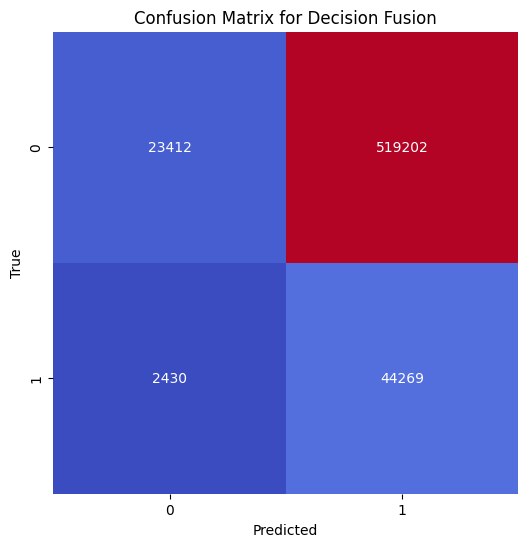


### Decision Fusion ###
Precision for Decision Fusion: 0.9060
Recall for Decision Fusion: 0.0431
F1-Score for Decision Fusion: 0.0824
Classification Report for Decision Fusion:

              precision    recall  f1-score   support

      Normal       0.91      0.04      0.08    542614
     Anomaly       0.08      0.95      0.15     46699

    accuracy                           0.11    589313
   macro avg       0.49      0.50      0.11    589313
weighted avg       0.84      0.11      0.09    589313



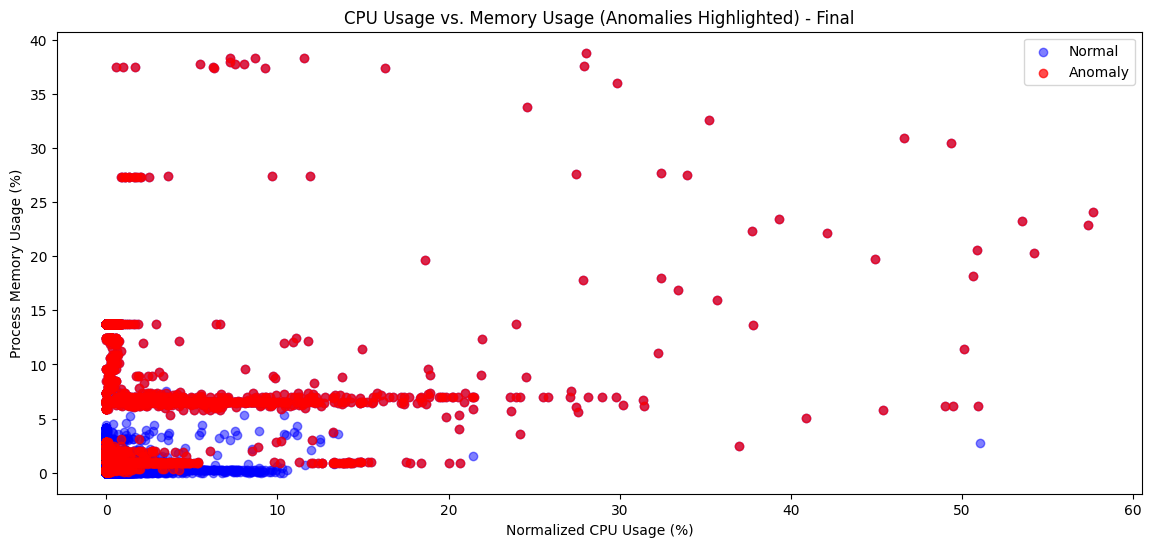

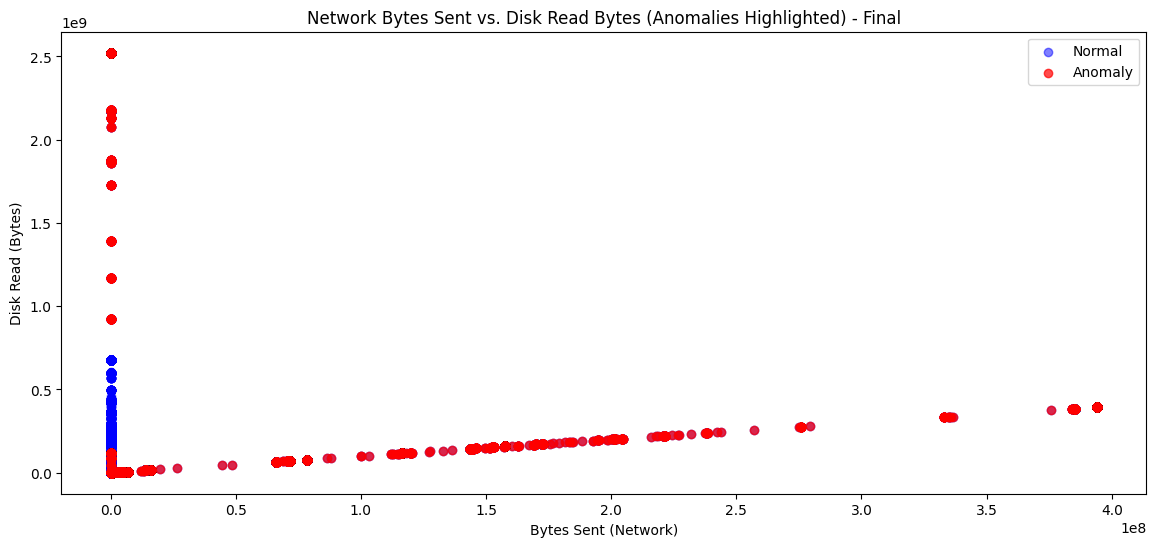

In [51]:
# Function for majority voting to combine model predictions
def decision_fusion(combined_data, model_names):
    # Check if all the model prediction columns exist
    for model_name in model_names:
        if f'{model_name} Anomaly' not in combined_data.columns:
            raise KeyError(f"'{model_name} Anomaly' column not found in combined_data")
        print(f"'{model_name} Anomaly' column found.")
    
    # Initialize an array to store the fused predictions
    fused_predictions = np.zeros(len(combined_data), dtype=int)

    # Collect predictions from each model and sum them
    for model_name in model_names:
        fused_predictions += combined_data[f'{model_name} Anomaly']

    # Convert summed predictions to final decision (-1 if more than half of the models predict anomaly)
    final_predictions = np.where(fused_predictions < 0, -1, 1)

    # Add final predictions to the dataset
    combined_data['Final Anomaly'] = final_predictions  # Fixed column name
    print("Added 'Final Anomaly' column.")

    # Confirm column exists after addition
    print("Columns after decision fusion:", combined_data.columns)
    if 'Final Anomaly' not in combined_data.columns:
        raise KeyError("'Final Anomaly' column was not created properly")

    # Evaluate and visualize the final confusion matrix
    evaluate_metrics('Decision Fusion', combined_data['True Labels'], combined_data['Final Anomaly'])

    # Visualize anomalies from decision fusion
    plot_anomalies('Final', combined_data)

# Function to print the columns before decision fusion
def check_columns(combined_data):
    print("Current columns in combined_data before fusion:", combined_data.columns)

# Main function calling
check_columns(combined_data)  # Print columns before running decision fusion
decision_fusion(combined_data, ['Elliptic Envelope', 'Isolation Forest', 'One-Class SVM'])


Dropping features

In [52]:
# Drop 'Disk Write (Bytes)' 'Bytes Sent (Network)' from numerical columns
reduced_numerical_columns = ['Normalized CPU Usage (%)', 'Process Memory Usage (%)', 
                             'Bytes Received (Network)', 
                             'Disk Read (Bytes)']

# Re-split the cleaned data without 'Disk Write (Bytes)'
train_data_reduced, test_data_reduced = train_test_split(non_zero_data[reduced_numerical_columns], test_size=0.1, random_state=42)
train_data_reduced.reset_index(drop=False, inplace=True)  # Keep original index with Timestamp
test_data_reduced.reset_index(drop=False, inplace=True)   # Keep original index with Timestamp

# Normalize the features for training using PowerTransformer (without 'Disk Write (Bytes)')
scaled_train_data_reduced = scaler.fit_transform(train_data_reduced[reduced_numerical_columns])
scaled_test_data_reduced = scaler.transform(test_data_reduced[reduced_numerical_columns])
scaled_attack_data_reduced = scaler.transform(non_zero_data_exploit[reduced_numerical_columns])

# Concatenate the test and exploit datasets without 'Disk Write (Bytes)'
scaled_combined_data_reduced = np.vstack([scaled_test_data_reduced, scaled_attack_data_reduced])

# Apply PCA for dimensionality reduction
pca_reduced = PCA(n_components=2)  # Reduce to 2 principal components
scaled_train_data_reduced_pca = pca_reduced.fit_transform(scaled_train_data_reduced)
scaled_combined_data_reduced_pca = pca_reduced.transform(scaled_combined_data_reduced)

# Assign True Labels: 1 for normal data, -1 for anomalies (exploit data)
combined_data_reduced = pd.concat([test_data_reduced, non_zero_data_exploit], ignore_index=True)
combined_data_reduced['True Labels'] = [1] * len(test_data_reduced) + [-1] * len(non_zero_data_exploit)

# Re-run models and visualizations


Re-run Elliptic Envelope

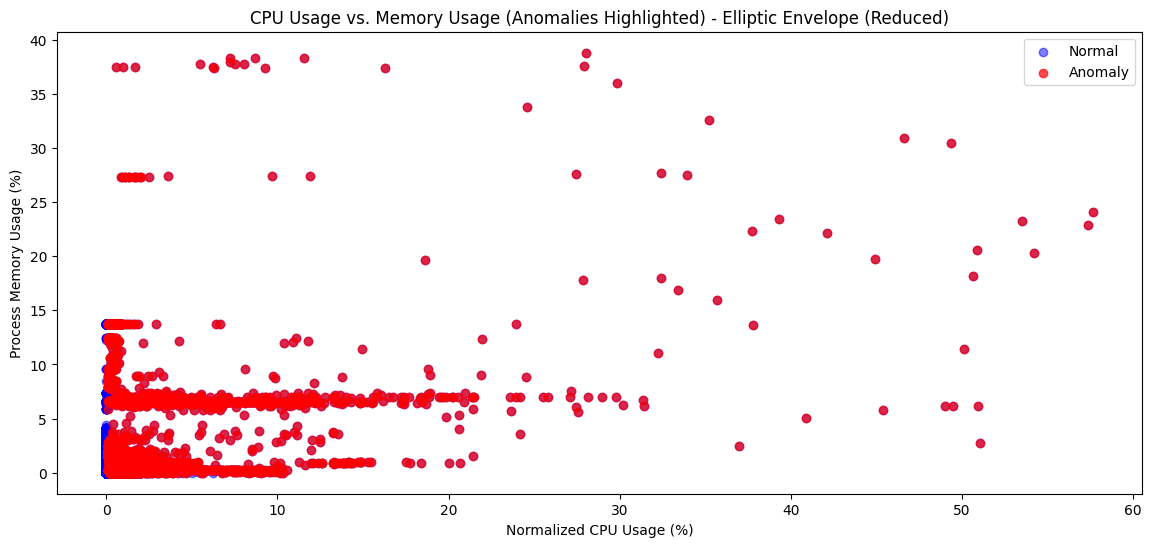

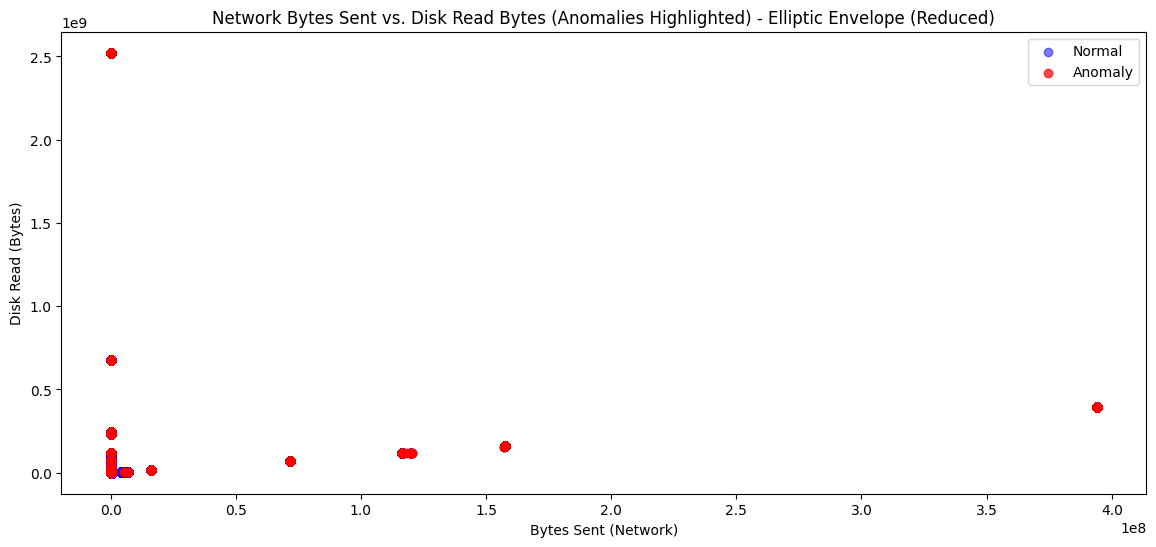

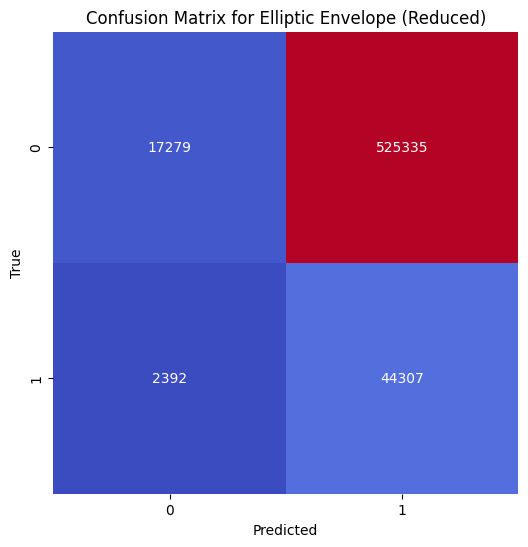


### Elliptic Envelope (Reduced) ###
Precision for Elliptic Envelope (Reduced): 0.8784
Recall for Elliptic Envelope (Reduced): 0.0318
F1-Score for Elliptic Envelope (Reduced): 0.0615
Classification Report for Elliptic Envelope (Reduced):

              precision    recall  f1-score   support

      Normal       0.88      0.03      0.06    542614
     Anomaly       0.08      0.95      0.14     46699

    accuracy                           0.10    589313
   macro avg       0.48      0.49      0.10    589313
weighted avg       0.81      0.10      0.07    589313



In [53]:

elliptic_model_reduced = EllipticEnvelope(contamination=0.05, support_fraction=0.7)
train_and_plot_anomalies('Elliptic Envelope (Reduced)', elliptic_model_reduced, scaled_train_data_reduced_pca, scaled_combined_data_reduced_pca, combined_data_reduced, threshold=-0.2)

Re-run Isolation Forest

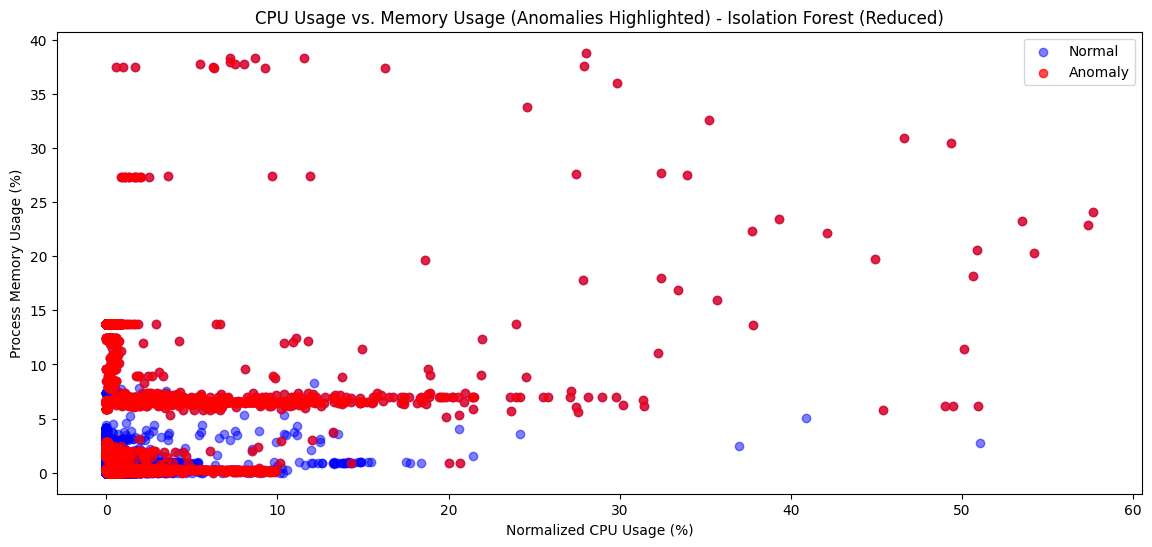

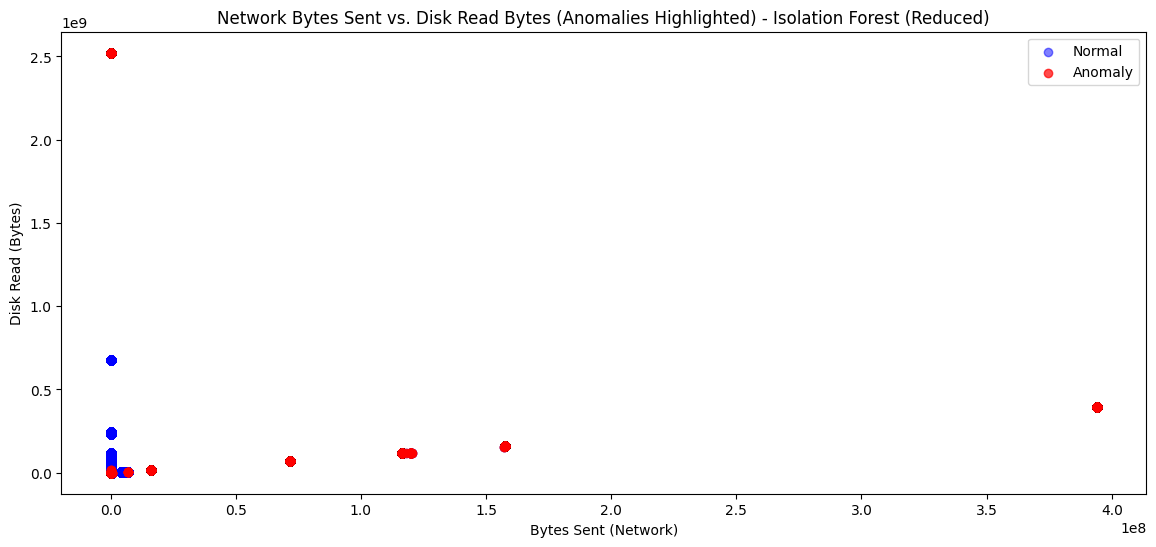

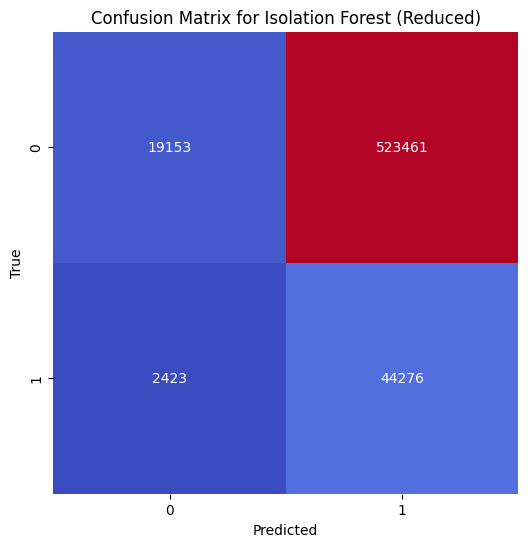


### Isolation Forest (Reduced) ###
Precision for Isolation Forest (Reduced): 0.8877
Recall for Isolation Forest (Reduced): 0.0353
F1-Score for Isolation Forest (Reduced): 0.0679
Classification Report for Isolation Forest (Reduced):

              precision    recall  f1-score   support

      Normal       0.89      0.04      0.07    542614
     Anomaly       0.08      0.95      0.14     46699

    accuracy                           0.11    589313
   macro avg       0.48      0.49      0.11    589313
weighted avg       0.82      0.11      0.07    589313



In [54]:
isolation_forest_reduced = IsolationForest(contamination=0.05, random_state=42)
train_and_plot_anomalies('Isolation Forest (Reduced)', isolation_forest_reduced, scaled_train_data_reduced_pca, scaled_combined_data_reduced_pca, combined_data_reduced)

Re-run One-Class SVM

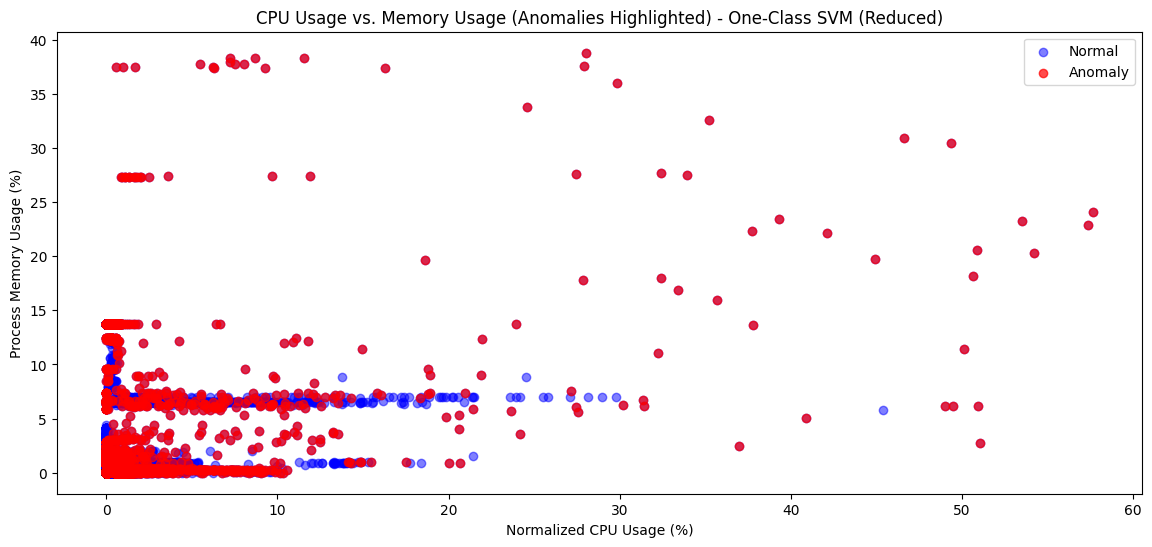

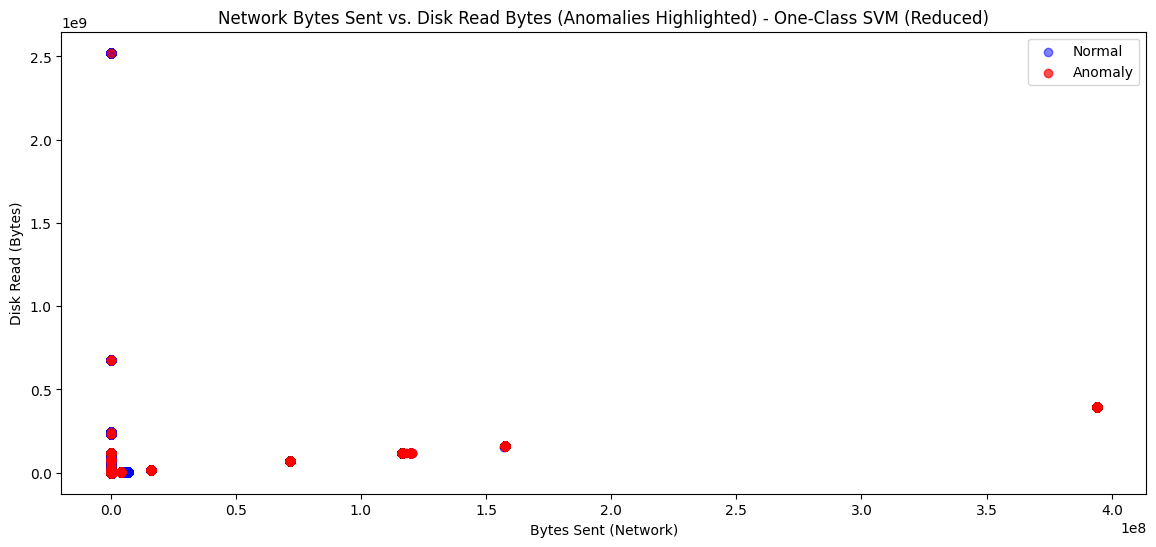

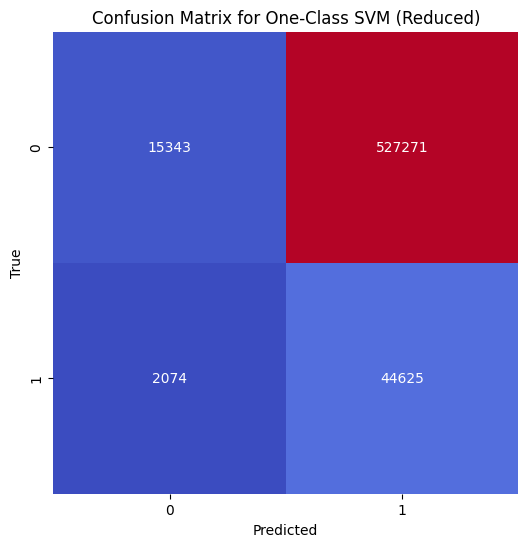


### One-Class SVM (Reduced) ###
Precision for One-Class SVM (Reduced): 0.8809
Recall for One-Class SVM (Reduced): 0.0283
F1-Score for One-Class SVM (Reduced): 0.0548
Classification Report for One-Class SVM (Reduced):

              precision    recall  f1-score   support

      Normal       0.88      0.03      0.05    542614
     Anomaly       0.08      0.96      0.14     46699

    accuracy                           0.10    589313
   macro avg       0.48      0.49      0.10    589313
weighted avg       0.82      0.10      0.06    589313



In [55]:
svm_model_reduced = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
train_and_plot_anomalies('One-Class SVM (Reduced)', svm_model_reduced, scaled_train_data_reduced_pca, scaled_combined_data_reduced_pca, combined_data_reduced)

Rerun Decision fusion

Columns before fusion: Index(['index', 'Normalized CPU Usage (%)', 'Process Memory Usage (%)',
       'Bytes Received (Network)', 'Disk Read (Bytes)', 'Timestamp',
       'Process Name', 'Process ID', 'Bytes Sent (Network)',
       'Disk Write (Bytes)', 'True Labels',
       'Elliptic Envelope (Reduced) Anomaly',
       'Isolation Forest (Reduced) Anomaly',
       'One-Class SVM (Reduced) Anomaly'],
      dtype='object')
'Elliptic Envelope (Reduced) Anomaly' column found.
'Isolation Forest (Reduced) Anomaly' column found.
'One-Class SVM (Reduced) Anomaly' column found.
Added 'Final (Reduced) Anomaly' column.
Columns after decision fusion: Index(['index', 'Normalized CPU Usage (%)', 'Process Memory Usage (%)',
       'Bytes Received (Network)', 'Disk Read (Bytes)', 'Timestamp',
       'Process Name', 'Process ID', 'Bytes Sent (Network)',
       'Disk Write (Bytes)', 'True Labels',
       'Elliptic Envelope (Reduced) Anomaly',
       'Isolation Forest (Reduced) Anomaly', 'One-Class SVM (

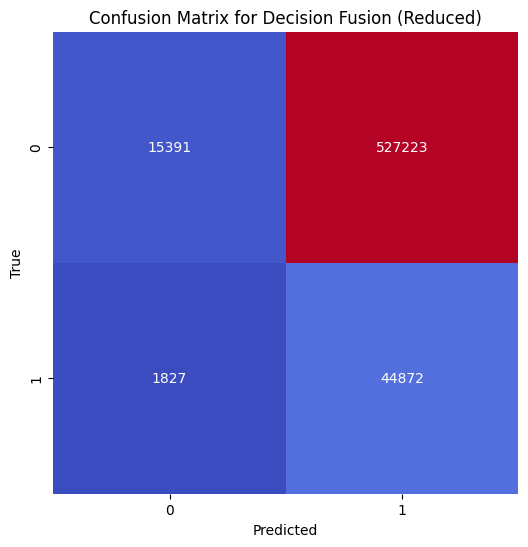


### Decision Fusion (Reduced) ###
Precision for Decision Fusion (Reduced): 0.8939
Recall for Decision Fusion (Reduced): 0.0284
F1-Score for Decision Fusion (Reduced): 0.0550
Classification Report for Decision Fusion (Reduced):

              precision    recall  f1-score   support

      Normal       0.89      0.03      0.05    542614
     Anomaly       0.08      0.96      0.15     46699

    accuracy                           0.10    589313
   macro avg       0.49      0.49      0.10    589313
weighted avg       0.83      0.10      0.06    589313



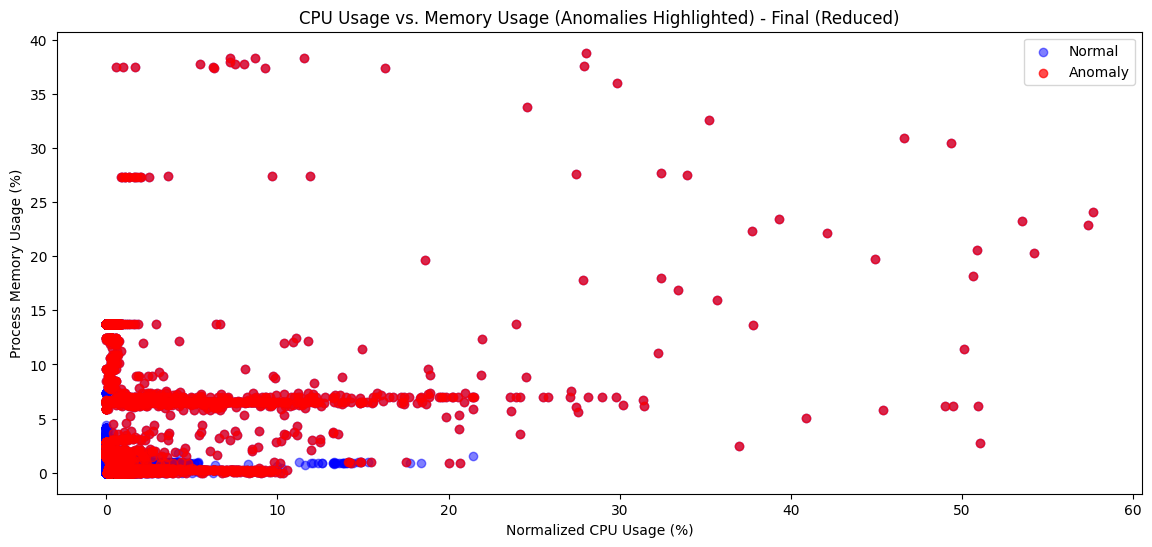

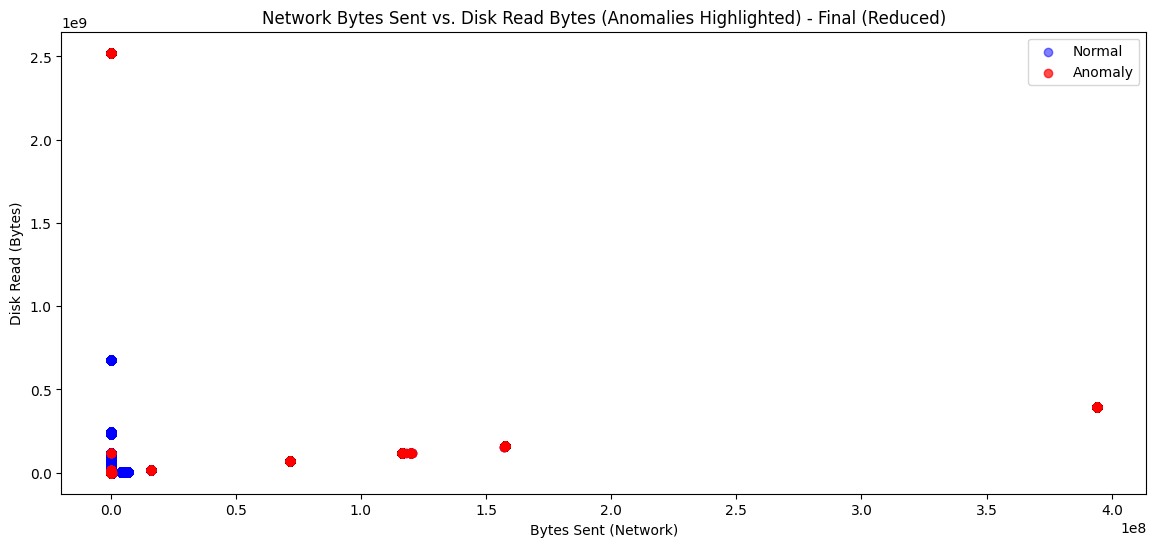

In [56]:
# Corrected function to write "Final (Reduced) Anomaly"
def decision_fusion_reduced(combined_data_reduced, model_names_reduced):
    # Check if all the model prediction columns exist
    for model_name in model_names_reduced:
        column_name = f'{model_name} Anomaly'
        if column_name not in combined_data_reduced.columns:
            raise KeyError(f"'{column_name}' column not found in combined_data_reduced")
        print(f"'{column_name}' column found.")
    
    # Initialize an array to store the fused predictions
    fused_predictions_reduced = np.zeros(len(combined_data_reduced), dtype=int)

    # Collect predictions from each model and sum them
    for model_name in model_names_reduced:
        fused_predictions_reduced += combined_data_reduced[f'{model_name} Anomaly']

    # Convert summed predictions to final decision (-1 if more than half of the models predict anomaly)
    final_predictions_reduced = np.where(fused_predictions_reduced < 0, -1, 1)

    # Add final predictions to the dataset with the name "Final (Reduced) Anomaly"
    combined_data_reduced['Final (Reduced) Anomaly'] = final_predictions_reduced  # Updated column name
    print("Added 'Final (Reduced) Anomaly' column.")

    # Confirm column exists after addition
    print("Columns after decision fusion:", combined_data_reduced.columns)
    if 'Final (Reduced) Anomaly' not in combined_data_reduced.columns:
        raise KeyError("'Final (Reduced) Anomaly' column was not created properly")

    # Evaluate and visualize the final confusion matrix
    evaluate_metrics('Decision Fusion (Reduced)', combined_data_reduced['True Labels'], combined_data_reduced['Final (Reduced) Anomaly'])

    # Visualize anomalies from decision fusion
    plot_anomalies('Final (Reduced)', combined_data_reduced)

# Before running decision fusion, print the columns to debug
print("Columns before fusion:", combined_data_reduced.columns)

# Run decision fusion with the model names used
decision_fusion_reduced(combined_data_reduced, ['Elliptic Envelope (Reduced)', 'Isolation Forest (Reduced)', 'One-Class SVM (Reduced)'])

# Save the reduced dataset with predictions to CSV, including "Final (Reduced) Anomaly"
combined_data_reduced.to_csv('combined_data_reduced_with_anomalies.csv', index=False)
